Found GPU at: /device:GPU:0
Processing images...

(1123, 100, 100, 3)
Processing images...

(10, 100, 100, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 20)        560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 40)        7240      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 40)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 80)        28880     
            

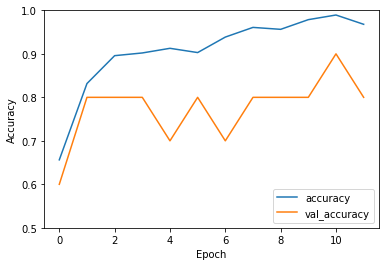

1/1 - 0s - loss: 0.7966 - accuracy: 0.8000 - 21ms/epoch - 21ms/step

Target Values: [1 1 1 2 2 3 2 3 0 0]
Test Results: [1 1 1 2 0 3 2 3 1 0]

Confusion Matrix:
[[1. 1. 0. 0.]
 [0. 3. 0. 0.]
 [1. 0. 2. 0.]
 [0. 0. 0. 2.]]

Test Accuracy: 0.800000011920929



In [1]:
""" Weather Classification Image Recognition using Google Tensorflow
    For ENEL 525 - Introduction to Machine Learning at the Schulich School of Engineering
    Created by: Patrick Robert Willmann

    Images will be classified as follows: Cloudy, Rainy, Sunshine, and Sunrise.
    Note: Filenames for training and test data should be named prefixed with:
    'cl' for cloudy, 'ra' for rainy, 'sh' for sunshine, and 'su' for sunrise.
"""

import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

model = models.Sequential()

def Process(path : str, resize : bool = True, dim : tuple = (50,50), greyScale : bool = False, kernel : str = None) -> np.ndarray:

    tempList = []
    targetList = []
    classifications = {'cl' : 0, 'ra' : 1, 'sh' : 2, 'su' : 3}

    print("Processing images...\n")

    for filename in os.listdir(path):
        
        # Ignore weird macOS hidden files
        if filename == '.DS_Store':
            continue

        # print(os.path.join(path,filename))

        img = cv2.imread(os.path.join(path,filename))

        if img is None:
            continue

        img = img[:,:,::-1] # Reverse channels to match source image
        
        # apply pre-processing
        if resize == True:
            img, check = Resize(img, dim, filename)
            if check == 1:
                continue
        
        if greyScale == True:
            img = GreyScale(img)
        
        if kernel != None:
            img = Filter(img, kernel)

        tempList.append(img)
        targetList.append(classifications[filename[0:2]])
        # print("Image Shape: " + str(img.shape))
    
    outList = np.asarray(tempList)/255.0
    outTarget = np.asarray(targetList)

    print(outList.shape)
    return outList, outTarget


""" Helper processing functions that needn't be directly accessed."""

def Resize(img, dim : tuple, fileName : str):

    try:
        out = cv2.resize(img, dim)
        return out, 0
    
    except Exception as e:
        print("Failed to resize image: " + fileName)
        return None, 1


def GreyScale(img) -> np.ndarray:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def Filter(img, kernel : str) -> np.ndarray:
    kernels = {'45deg' : np.array([[-1,-1,2], [-1,2,-1], [2,-1,-1]]),
               '90deg' : np.array([[0,-1,0], [-1,4,-1], [0,-1,0]]),
               'gabor' : cv2.getGaborKernel((21,21), 3.0, 0.0, 10.0, 0.5, 0, ktype = cv2.CV_32F)}
    
    return cv2.filter2D(img, -1, kernels[kernel])


""" Helper module to extract a random selection of images from the training data set to be used for testing purposes."""

def ExtractRandomTest(trainingSet : np.ndarray, targetList : np.ndarray, percentTest : float = 0.10) -> np.ndarray:

    trainingSize = len(trainingSet)
    testImagesCount = int(percentTest * float(trainingSize))
    print(str(testImagesCount) + " images will be randomly selected as test images.\n")

    indexList = random.sample(range(0, trainingSize - 1), testImagesCount)

    testSet = trainingSet[indexList]
    testTarget = np.take(targetList, indexList)

    print("Shape of original training set: " + str(trainingSet.shape))
    print("Shape of output test set: " + str(testSet.shape))

    return testSet, testTarget


""" This module contains the tensorflow convolutional neural network.
    Input Arguments: 
    - trainingData (numpy array): Pre-processed images for training
    - epochs (int): Number of epochs
    - more....
    """

def Train(trainingData : np.ndarray, trainingTargets : np.ndarray, testData : np.ndarray, testTargets : np.ndarray, dim : tuple, epochs : int = 10):

    model.add(layers.Conv2D(20, (3, 3), activation = 'relu', input_shape = (dim[0], dim[1], 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(40, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(80, (3, 3), activation = 'relu'))

    # Flatten 3D layers into 1D then feed into Dense layers for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(80, activation = 'relu'))
    model.add(layers.Dense(4))
    model.summary()

    # Compile, train, and test the model
    model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

    history = model.fit(trainingData, trainingTargets, epochs = epochs, validation_data = (testData, testTargets))

    # Perform Analysis

    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc = 'lower right')
    plt.show()

    return model.evaluate(testData, testTargets, verbose=2)


def Test(testData):
    return oneHotDec(model.predict(testData))


def compute_confusion_matrix(targetVals, predVals):
  K = len(np.unique(targetVals)) # Number of classes
  result = np.zeros((K, K))
  for i in range(len(targetVals)):
    result[targetVals[i]][predVals[i]] += 1
  return result


def oneHotDec(predVals):
  result = np.zeros(len(predVals))
  for i, val in enumerate(predVals):
    result[i] = (np.argmax(val))
  return result


if __name__ == "__main__":

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

    # Initialize Default Values
    customTest = False
    dataPaths = ["/content/drive/MyDrive/ENEL 525 - Machine Learning for Engineers/Course Project/Final Project/Dataset", "/content/drive/MyDrive/ENEL 525 - Machine Learning for Engineers/Course Project/Final Project/Tests"]
    dimensions = (100,100)
    epochs = 12

    # Parse Input Args
    if dataPaths[0] != dataPaths[1]:
        customTest = True


    # Import & Process Images

    trainingImages, trainingTargets = Process(dataPaths[0], dim = dimensions)

    if customTest == True:
        testImages, testTargets = Process(dataPaths[1], dim = dimensions)
    else:
        # Take a subset of images from trainingImages list to testImages list
        testImages, testTargets = ExtractRandomTest(trainingImages, trainingTargets)


    # Train and Test the Pre-Processed Dataset

    testLoss, testAcc = Train(trainingImages,trainingTargets, testImages, testTargets, dimensions, epochs)
    
    testResults = Test(testImages)
    testResults = testResults.astype(int)
    confusionMatrix = compute_confusion_matrix(testTargets, testResults)
    
    print("\nTarget Values: " + str(testTargets))
    print("Test Results: " + str(testResults) + "\n")
    print("Confusion Matrix:\n" + str(confusionMatrix) + "\n")
    print("Test Accuracy: " + str(testAcc) + "\n")
